In [14]:
import gc

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

from sklearn.model_selection import train_test_split as tts

from sklearn.metrics import accuracy_score, precision_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [15]:
class Learner():
    def __init__(self, classes : tuple, n_estimators : tuple, max_depths : tuple, train_df : pd.DataFrame, test_df : pd.DataFrame, submission_df : pd.DataFrame):
        self.classes = classes
        self.n_estimators = n_estimators
        self.max_depths = max_depths
        self.train_df = train_df
        self.test_df = test_df
        self.submission_df = submission_df

        self.scored_classifiers = []
        self.classification_reports = []
    
    def split_dataset(self):        
        self.train_input, self.validation_input, self.train_output, self.validation_output = tts(self.train_df.drop(columns=["id", "status_group", "date_recorded"]), self.train_df["status_group"], test_size=0.3)
        return self.train_input, self.validation_input, self.train_output, self.validation_output
    
    def create_file(self, predicited_output, file_num : str):
        if predicited_output.shape[0] == self.submission_df.shape[0]:
            print(True)
            submission = self.submission_df.copy()
            for (idx,data) in submission["status_group"].iteritems():
                submission["status_group"][idx] = self.classes[predicited_output[idx]]                
            submission.to_csv("./datasets/submissions/submission_" + file_num + ".csv", index=False, header=True)
            del submission
            gc.collect()
    
    def create_classifier(self, depth : int, estimator : int):
        classifer_model = RandomForestClassifier(max_depth=depth, n_estimators=estimator, n_jobs=-1)
        return classifer_model
    
    def train_model(self):
        dataset = self.split_dataset()
        for estimator in n_estimators:
            for max_depth in max_depths:
                classifier = self.create_classifier(depth=max_depth, estimator=estimator)
                classifier.fit(dataset[0], dataset[2])
                predicted_output = classifier.predict(dataset[1])
                acc_score = accuracy_score(predicted_output, dataset[3])

                self.classification_reports.append(self.create_classification_report(dataset[3], predicted_output)                )
                self.scored_classifiers.append((estimator, max_depth, classifier, acc_score))
    
    def test_model(self, classifier : RandomForestClassifier,file_num : int,  create_file=True):
        self.test_df = self.test_df.fillna(self.test_df.median())
        predicted_output = classifier.predict(self.test_df.drop(columns=["id", "date_recorded"]))
        if create_file:
            self.create_file(predicted_output, str(file_num))
        return predicted_output
    
    def plot_confusion_matrix(self, classifier : RandomForestClassifier):
        plot_conf_matrix = plot_confusion_matrix(classifier, self.validation_input, self.validation_output, display_labels=classes, cmap=plt.cm.Blues, normalize='true') 
        return plot_conf_matrix
    
    def create_classification_report(self, validation_output, predicted_output):
        report = classification_report(validation_output, predicted_output, output_dict=True)   
        return pd.DataFrame(report).transpose()

## Public Variables

In [16]:
classes = ("functional", "functional needs repair","non functional")
n_estimators = (100, 200)
max_depths = (40, 41, 42)

In [17]:
train_df = pd.read_csv("./datasets/preprocessed_data/merged_train.csv")
test_df = pd.read_csv("./datasets/preprocessed_data/test.csv")
submission_df = pd.read_csv("./datasets/SubmissionFormat.csv")

In [18]:
train_df.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,1559.0,1390,1764.0,34.938093,-9.856322,5520,0,...,2,5,3,3,3,2,2,0,0,0
1,8776,0.0,2013-03-06,1731.0,1399,1868.0,34.698766,-2.147466,17493,0,...,2,5,4,4,0,0,0,0,0,0
2,34310,25.0,2013-02-25,1431.0,686,1732.0,37.460664,-3.821329,37342,0,...,2,5,3,3,5,3,0,3,0,0
3,67743,0.0,2013-01-28,1265.0,263,1254.0,38.486161,-11.155298,12,0,...,2,5,1,1,4,5,2,3,0,2
4,19728,0.0,2011-07-13,1555.0,0,1454.0,31.130847,-1.825359,29877,0,...,2,5,2,2,0,0,0,0,0,0


In [19]:
test_df.head(5)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,1795.0,1996,1832.0,35.290799,-4.059696,7003,0,...,3,2,5,2,2,0,0,0,6,5
1,51630,0.0,2013-02-04,1967.0,1569,1300.0,36.656709,-3.309214,14711,0,...,3,2,5,4,4,3,2,2,0,0
2,17168,0.0,2013-02-01,1334.0,1567,1300.0,34.767863,-5.004344,14742,0,...,3,2,5,4,4,0,0,0,6,5
3,45559,0.0,2013-01-22,381.0,267,2349.0,38.058046,-9.418672,7335,0,...,2,2,5,1,1,2,1,2,6,5
4,49871,500.0,2013-03-27,615.0,1260,774.0,35.006123,-10.950412,30637,0,...,1,2,5,3,3,3,2,2,0,0


In [20]:
submission_df.head(5)

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label
3,45559,predicted label
4,49871,predicted label


## Train the Model then predict the test values

In [21]:
learner = Learner(classes=classes, n_estimators=n_estimators, max_depths=max_depths, train_df=train_df, test_df=test_df, submission_df=submission_df)


In [22]:
learner.train_model()

In [23]:
for report in learner.classification_reports:
    print(report)
    print()
    print("*" * 90)
    print()

precision    recall  f1-score       support
0              0.805378  0.898268  0.849291   9702.000000
1              0.570106  0.332305  0.419873   1297.000000
2              0.849271  0.777305  0.811696   6821.000000
accuracy       0.810774  0.810774  0.810774      0.810774
macro avg      0.741585  0.669293  0.693620  17820.000000
weighted avg   0.805055  0.810774  0.803646  17820.000000

******************************************************************************************

              precision    recall  f1-score       support
0              0.807037  0.898371  0.850259   9702.000000
1              0.560052  0.330763  0.415899   1297.000000
2              0.849856  0.779211  0.813002   6821.000000
accuracy       0.811448  0.811448  0.811448      0.811448
macro avg      0.738982  0.669449  0.693053  17820.000000
weighted avg   0.805451  0.811448  0.804384  17820.000000

******************************************************************************************

              pr

In [24]:
classifiers = learner.scored_classifiers

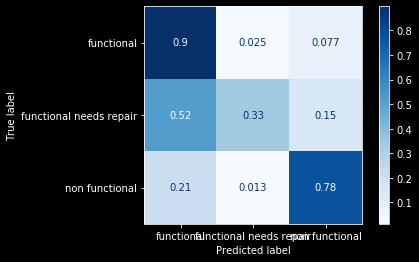

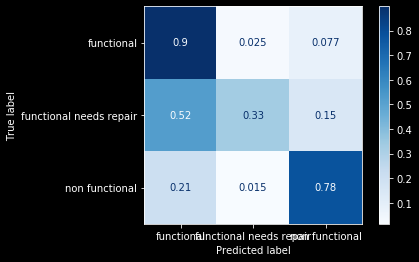

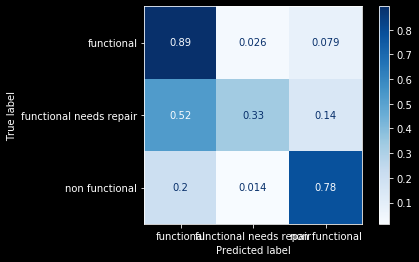

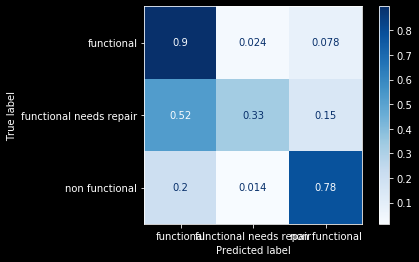

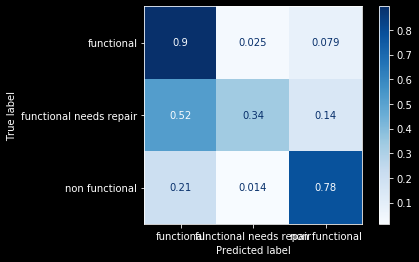

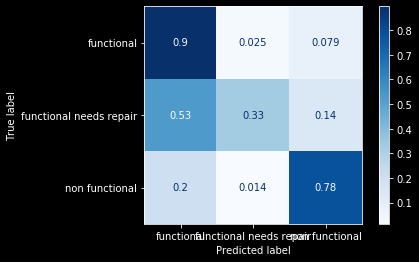

In [25]:
for tuple_item in classifiers:
    plot = learner.plot_confusion_matrix(classifier=tuple_item[2])
plt.show()

In [26]:
for tuple_item in classifiers:
    predicted_output = learner.test_model(classifier=tuple_item[2], file_num=tuple_item[0]+tuple_item[1])

True
True
True
True
True
True
